# GNN-based URA Clustering

This notebook trains a Graph Neural Network to cluster a $16 \times 16$ antenna array.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

from gnn import (
    URAConfig,
    create_ura_graph,
    compute_mutual_coupling,
    train_ura_clustering,
    train_ura_clustering_simple,
    assignments_to_antenna_format,
)

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

c:\Users\Andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.9.1+cpu
CUDA: False


## 1. Configuration

In [2]:
config = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=10.0)
print(f"Array: {config.N} elements")
print(f"Spacing: dx={config.dx}λ, dy={config.dy}λ")

Array: 256 elements
Spacing: dx=0.5λ, dy=0.7λ


## 2. Train GNN

Using the **simple** training mode which is more stable.

In [3]:
num_clusters = 4

print("Training GNN (simple mode)...\n")
clusters = train_ura_clustering_simple(
    config,
    num_clusters=num_clusters,
    epochs=300,
    verbose=True
)

# Get cluster sizes (handle missing clusters)
unique_clusters = np.unique(clusters)
sizes = np.bincount(clusters, minlength=num_clusters)
print(f"\nCluster sizes: {sizes.tolist()}")
print(f"Unique clusters found: {unique_clusters.tolist()}")

Training GNN (simple mode)...

Epoch 100: Loss=-0.8988, Sizes=[66, 63, 64, 63]
Epoch 200: Loss=-0.9024, Sizes=[65, 67, 64, 60]
Epoch 300: Loss=-0.9032, Sizes=[66, 64, 67, 59]

Cluster sizes: [64, 65, 66, 61]
Unique clusters found: [0, 1, 2, 3]


## 3. Visualize Results

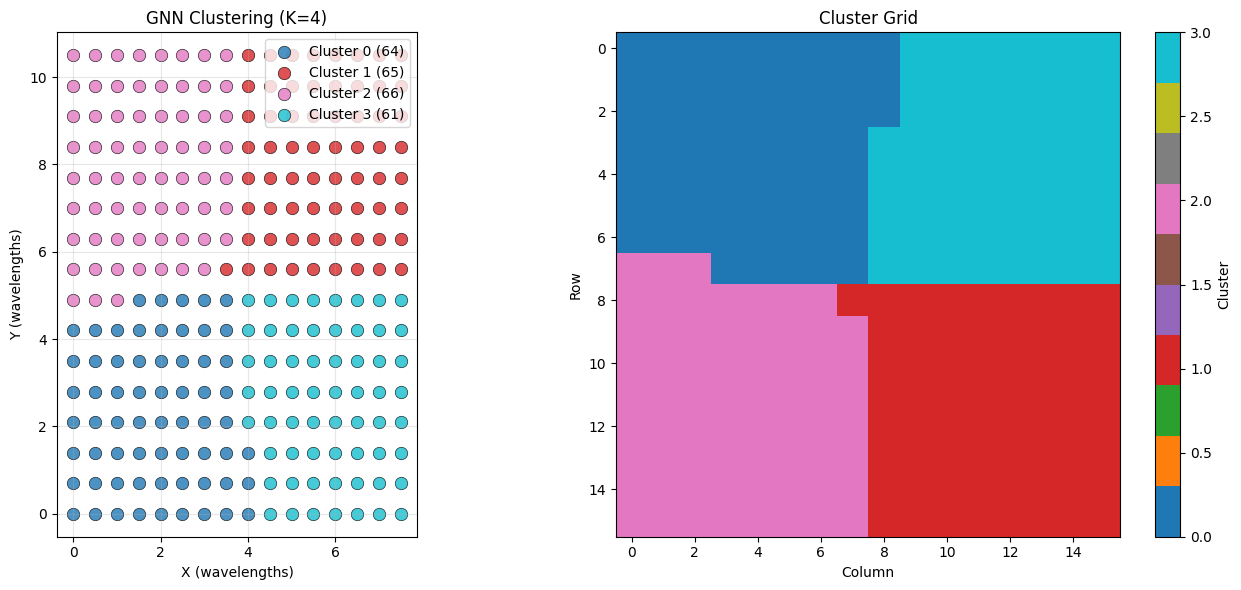


Cluster grid:
[[0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [2 2 2 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]]


In [4]:
# Get positions
positions, _, _, _ = create_ura_graph(config, use_coupling=False)
pos_np = positions.numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))
sizes_array = np.bincount(clusters, minlength=num_clusters)

for k in range(num_clusters):
    mask = clusters == k
    if mask.sum() > 0:  # Only plot if cluster has elements
        axes[0].scatter(pos_np[mask, 0], pos_np[mask, 1],
                        c=[colors[k]], s=80, 
                        label=f'Cluster {k} ({sizes_array[k]})',
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'GNN Clustering (K={num_clusters})')
axes[0].legend(loc='upper right')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Grid view
grid = clusters.reshape(config.rows, config.cols)
im = axes[1].imshow(grid, cmap='tab10', vmin=0, vmax=num_clusters-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("\nCluster grid:")
print(grid)

## 4. (Optional) Physics-Informed Training

This uses mutual coupling but may need parameter tuning.

In [5]:
print("Training GNN (physics-informed mode)...\n")
clusters_physics = train_ura_clustering(
    config,
    num_clusters=num_clusters,
    epochs=500,
    lr=0.001,
    use_physics=True,
    lambda_balance=10.0,  # HIGH to force balanced clusters
    lambda_contiguity=0.1,
    verbose=True
)

sizes_physics = np.bincount(clusters_physics, minlength=num_clusters)
print(f"\nPhysics-informed cluster sizes: {sizes_physics.tolist()}")

Training GNN (physics-informed mode)...

Epoch 100: Loss=0.4052 | Sizes=[93, 37, 45, 81] | cut=-1.000, bal=0.000
Epoch 200: Loss=0.4052 | Sizes=[68, 35, 65, 88] | cut=-1.000, bal=0.000
Epoch 300: Loss=0.4052 | Sizes=[74, 36, 55, 91] | cut=-1.000, bal=0.000
Epoch 400: Loss=0.4052 | Sizes=[81, 38, 46, 91] | cut=-1.000, bal=0.000
Epoch 500: Loss=0.4052 | Sizes=[81, 38, 46, 91] | cut=-1.000, bal=0.000

Physics-informed cluster sizes: [81, 38, 47, 90]


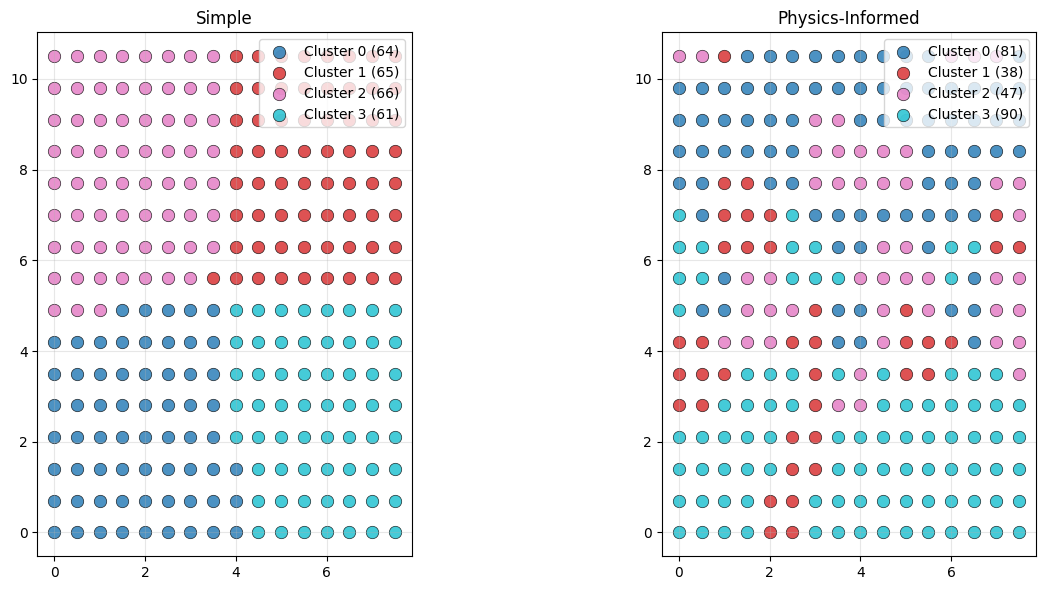

In [6]:
# Compare both results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, cl, title in [(axes[0], clusters, 'Simple'), 
                       (axes[1], clusters_physics, 'Physics-Informed')]:
    sizes_cl = np.bincount(cl, minlength=num_clusters)
    for k in range(num_clusters):
        mask = cl == k
        if mask.sum() > 0:
            ax.scatter(pos_np[mask, 0], pos_np[mask, 1],
                      c=[colors[k]], s=80,
                      label=f'Cluster {k} ({sizes_cl[k]})',
                      alpha=0.8, edgecolors='black', linewidth=0.5)
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Radiation Pattern (if available)

Computing radiation pattern...


c:\Users\Andrea\Desktop\Huawei\irregular\gnn\..\gnn\plot_gnn_radiation.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


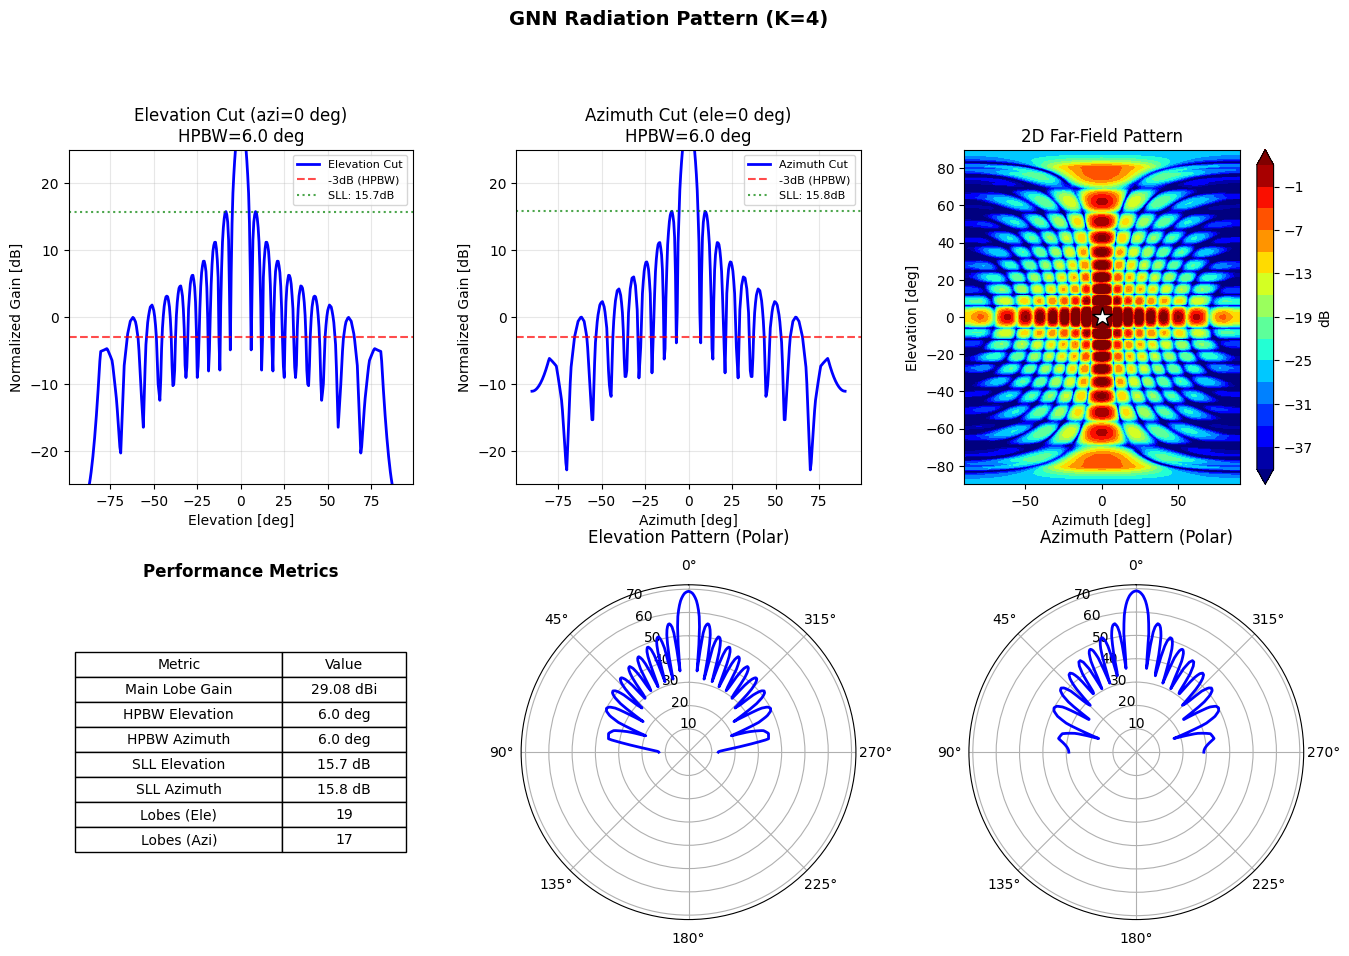

In [7]:
try:
    from gnn.plot_gnn_radiation import plot_gnn_radiation_pattern
    print("Computing radiation pattern...")
    metrics = plot_gnn_radiation_pattern(clusters, num_clusters, (config.rows, config.cols))
except ImportError as e:
    print(f"Radiation pattern not available: {e}")